In [2]:
import math
import numpy as np
import torch
from torch import nn

from shiba import Trainer
from shiba.steps import rnn_step
from shiba.callbacks import LambdaCallback, TensorBoard, Metric, Save
from shiba.utils import model_summary

from data import Corpus, LMLoader
from model import LSTMLM

## Load and Tokenize Data

In [3]:
%time corpus = Corpus(path='data/wikitext-2/')

CPU times: user 20.9 s, sys: 42.8 ms, total: 21 s
Wall time: 21 s


## Set Hyperparams

In [4]:
vocab_size = len(corpus.dictionary) # num unique tokens in dictionary, 33278
batch_size = 32
eval_batch_size = 12
seq_len = 35 # sometimes called back prop through time (bptt) length during training.
variable_length = True

embedding_size = 10
hidden_size = 20

In [5]:
train_loader = LMLoader(corpus.train, batch_size, seq_len, variable_length)
valid_loader = LMLoader(corpus.valid, batch_size, seq_len, variable_length)
test_loader = LMLoader(corpus.test, batch_size, seq_len, variable_length)

## Example Sequence

In [6]:
i2w = corpus.dictionary.idx2word

def to_words(indices):
    return np.array([i2w[i] for i in indices])

In [7]:
inputs, targets = next(train_loader)

In [15]:
to_words(inputs[:,0]), to_words(targets[:,0])

(array(['<eos>', '=', 'Valkyria', 'Chronicles', 'III', '=', '<eos>',
        '<eos>', 'Senjō', 'no', 'Valkyria', '3', ':', '<unk>',
        'Chronicles', '(', 'Japanese', ':', '戦場のヴァルキュリア3', ',', 'lit', '.',
        'Valkyria', 'of', 'the', 'Battlefield', '3', ')', ',', 'commonly',
        'referred', 'to', 'as', 'Valkyria', 'Chronicles'], dtype='<U11'),
 array(['=', 'Valkyria', 'Chronicles', 'III', '=', '<eos>', '<eos>',
        'Senjō', 'no', 'Valkyria', '3', ':', '<unk>', 'Chronicles', '(',
        'Japanese', ':', '戦場のヴァルキュリア3', ',', 'lit', '.', 'Valkyria', 'of',
        'the', 'Battlefield', '3', ')', ',', 'commonly', 'referred', 'to',
        'as', 'Valkyria', 'Chronicles', 'III'], dtype='<U11'))

## Define Model

In [18]:
model = LSTMLM(vocab_size=vocab_size, embedding_size=10, hidden_size=20, nlayers=2, dropout=0.5)
hidden = model.init_hidden(batch_size)

## count parameters

In [20]:
model_summary(model, inputs, hidden) # batch size 1

| Name    | Output Size             | Parameters   |
|:--------|:------------------------|:-------------|
| encoder | (35, 32, 10)            | 332,780      |
| dropout | (35, 32, 10)            | 0            |
| lstm    | [(32, 20), (2, 32, 20)] | 5,920        |
| decoder | (35, 32, 33278)         | 698,838      |
| TOTAL:  | -----------------       | 1,037,538    |

## Trainer

In [26]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors,
    to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


def rnn_step(trainer, batch):
    hidden = repackage_hidden(trainer.out['hidden'])
    inputs, targets = batch  # inputs.shape : (batch, seq)
    outputs, hidden = trainer.model(inputs, hidden)
    batch_seq_len, batch_size, vocab_size = outputs.shape
    loss = trainer.criterion(outputs.view(-1, vocab_size), targets.view(-1)) * (batch_seq_len / seq_len)  # rescale for variable sequence lengths
    return dict(loss=loss,
                inputs=inputs,
                outputs=outputs,
                hidden=hidden,
                targets=targets)

In [27]:
criterion = nn.CrossEntropyLoss()
torch.op
trainer = Trainer(model, criterion, train_step=rnn_step)

## callbacks

In [28]:
def clip_grad_norm(trainer, max_norm=0.25):
    torch.nn.utils.clip_grad_norm_(trainer.model.parameters(), max_norm)

def perpexity(loss):
    # exp of cross entropy loss
    return math.exp(loss)
    
callbacks = [TensorBoard(log_dir='runs/shiba-test-lm'),
             Metric('perpexity', 
                    score_func=perpexity,
                    transform=lambda x: x['loss'].item()),
             Save('weights/test-lm', monitor='val_perpexity'),
#              LambdaCallback(on_batch_end=clip_grad_norm)
            ]
!rm -rf runs/shiba-test-lm # clear tb logs

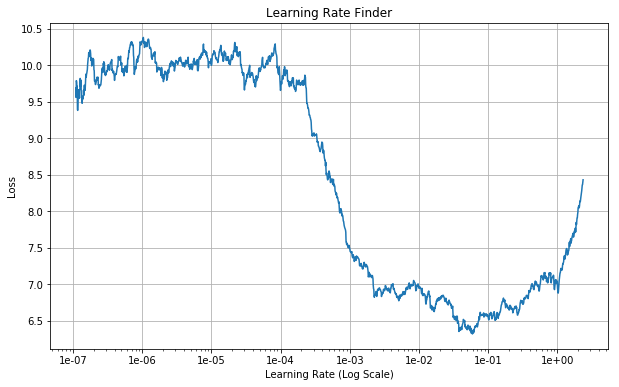

In [29]:
trainer.find_lr(train_loader)

In [30]:
trainer.fit_one_cycle(train_loader, valid_loader, epochs=4, max_lr=2e-3, callbacks=callbacks)